# Classfication Network Architecture

I am unable to get flowers classification network to get a validation accuracy > 48%. Try out different techniques including the same architecture I used to train CIFAR10 images

@date: 06-Aug-2020 | @author: katnoria

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [5]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [6]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

Use the built in function to visualise the dataset 

In [10]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [11]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


### Training Pipeline

In [10]:
IMG_SIZE = 32
BATCH_SIZE = 256


def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255., label

In [11]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [12]:
example = ds_train.take(1)

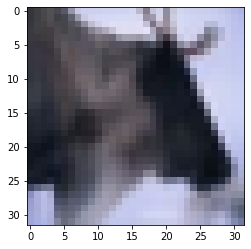

In [16]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [12]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

In [19]:
class FlowersModel(Model):
    def __init__(self):
        super(FlowersModel, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same')
#         self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, 3, padding='same')
        self.pool1 = MaxPool2D(3, 2)
#         self.bn2 = BatchNormalization()        
        self.pool2 = MaxPool2D(3, 2)        
        self.conv3 = Conv2D(128, 3, padding='same')
        self.pool3 = MaxPool2D(3, 2)            
        self.gap = GlobalAveragePooling2D()        
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(NUM_CLASSES)
        
    def call(self, x, training=False):
        x = self.conv1(x)
        # using batchnorm results in very low test accuracies
        # https://stackoverflow.com/questions/40081697/getting-low-test-accuracy-using-tensorflow-batch-norm-function
        # Probably this could help
#         x = self.bn1(x, training=training)
        x = self.pool1(tf.nn.leaky_relu(x))
        # conv 2
        x = self.conv2(x)
#         x = self.bn2(x, training=training)
        x = tf.nn.leaky_relu(x)
        x = self.pool2(x)
        # conv 3
        x = self.conv3(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool3(x)
        # GAP + Linear
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        out = self.dense2(x)
        return out
    
class FlowersModelBN(Model):
    def __init__(self):
        super(FlowersModel, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, 3, padding='same')
        self.pool1 = MaxPool2D(3, 2)
        self.bn2 = BatchNormalization()        
        self.pool2 = MaxPool2D(3, 2)        
        self.flatten = Flatten()
        self.gap = GlobalAveragePooling2D()
        self.dense1 = Dense(128, activation='relu')        
        self.dense2 = Dense(NUM_CLASSES)
        
    def call(self, x, training=False):
        x = self.conv1(x)
        # using batchnorm results in very low test accuracies
        # https://stackoverflow.com/questions/40081697/getting-low-test-accuracy-using-tensorflow-batch-norm-function
        # Probably this could help
#         x = self.bn1(x, training=training)
        x = self.pool1(tf.nn.leaky_relu(x))
        
        x = self.conv2(x)
#         x = self.bn2(x, training=training)
        x = tf.nn.leaky_relu(x)
        x = self.pool2(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = tf.nn.dropout(x, rate=0.2)
        out = self.dense2(x)
        return out    

In [27]:
model = FlowersModel()

Create the loss function and optimizer

In [21]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)

We are going to measure the train and test accuracy of the model

In [22]:
# Train
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

# Test
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

We now train the model

In [23]:
# Training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # collect the gradients and apply
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # loss & acc
    train_loss(loss)
    train_acc(labels, predictions)
    
    
# Test step    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    # loss & acc
    test_loss(loss)
    test_acc(labels, predictions)

# Train the model

Now, its time to train the model for N epochs

In [45]:
# With 2 conv layers + GAP + 2 Linear Layers
num_epochs = 1000
print_every = int(0.1 * num_epochs)

for epoch in range(1, num_epochs+1):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for tst_images, tst_labels in test_ds:
        test_step(tst_images, tst_labels)
        
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}: loss={train_loss.result():.4f}, accuracy: {train_acc.result():.4f} :: test loss={test_loss.result():.4f}, test accuracy: {test_acc.result():.4f}")

Epoch 101: loss=0.9519, accuracy: 0.6601 :: test loss=0.9616, test accuracy: 0.6582
Epoch 201: loss=0.8008, accuracy: 0.7150 :: test loss=0.8934, test accuracy: 0.6847
Epoch 301: loss=0.7276, accuracy: 0.7389 :: test loss=0.8986, test accuracy: 0.6996
Epoch 401: loss=0.6607, accuracy: 0.7612 :: test loss=0.8968, test accuracy: 0.7161
Epoch 501: loss=0.6333, accuracy: 0.7736 :: test loss=0.9269, test accuracy: 0.7085
Epoch 1001: loss=0.5242, accuracy: 0.8095 :: test loss=1.0011, test accuracy: 0.7085


In [28]:
# With 3 conv layers + GAP + 2 Linear Layers
num_epochs = 1000
print_every = int(0.1 * num_epochs)

for epoch in range(1, num_epochs+1):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for tst_images, tst_labels in test_ds:
        test_step(tst_images, tst_labels)
        
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}: loss={train_loss.result():.4f}, accuracy: {train_acc.result():.4f} :: test loss={test_loss.result():.4f}, test accuracy: {test_acc.result():.4f}")

Epoch 101: loss=0.3940, accuracy: 0.8594 :: test loss=0.9450, test accuracy: 0.7091
Epoch 201: loss=0.1793, accuracy: 0.9353 :: test loss=1.2561, test accuracy: 0.7294
Epoch 301: loss=0.0909, accuracy: 0.9673 :: test loss=1.8072, test accuracy: 0.7250
Epoch 401: loss=0.0799, accuracy: 0.9718 :: test loss=2.1159, test accuracy: 0.7239
Epoch 501: loss=0.0652, accuracy: 0.9771 :: test loss=2.4370, test accuracy: 0.7192
Epoch 601: loss=0.0464, accuracy: 0.9843 :: test loss=2.6713, test accuracy: 0.7207
Epoch 701: loss=0.0324, accuracy: 0.9890 :: test loss=2.9422, test accuracy: 0.7193
Epoch 801: loss=0.0344, accuracy: 0.9884 :: test loss=3.0850, test accuracy: 0.7257
Epoch 901: loss=0.0275, accuracy: 0.9901 :: test loss=3.1707, test accuracy: 0.7266
Epoch 1001: loss=0.0384, accuracy: 0.9866 :: test loss=3.3447, test accuracy: 0.7220


In [30]:
tf.saved_model.save(model, "models")

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


# Use Keras fit Method

An easier way is to just use the keras fit method

In [88]:
model = FlowersModel()
model.compile(
    loss=loss_fn, 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],    
)
model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
  1/195 [..............................] - ETA: 0s - loss: 2.4158 - accuracy: 0.0820WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.0052s). Check your callbacks.


195/195 [==============================] - 2s 10ms/step - loss: 1.4477 - accuracy: 0.4803 - val_loss: 2.3369 - val_accuracy: 0.1000
Epoch 2/10
195/195 [==============================] - 2s 9ms/step - loss: 1.0864 - accuracy: 0.6147 - val_loss: 6.5635 - val_accuracy: 0.1000
Epoch 3/10
195/195 [==============================] - 2s 9ms/step - loss: 0.9503 - accuracy: 0.6647 - val_loss: 9.6181 - val_accuracy: 0.1012
Epoch 4/10
195/195 [==============================] - 2s 9ms/step - loss: 0.8772 - accuracy: 0.6907 - val_loss: 34.9941 - val_accuracy: 0.1000
Epoch 5/10
195/195 [==============================] - 2s 9ms/step - loss: 0.8220 - accuracy: 0.7115 - val_loss: 66.8259 - val_accuracy: 0.1033
Epoch 6/10
195/195 [==============================] - 2s 10ms/step - loss: 0.7678 - accuracy: 0.7300 - val_loss: 61.1285 - val_accuracy: 0.1003
Epoch 7/10
195/195 [==============================] - 2s 9ms/step - loss: 0.7311 - accuracy: 0.7434 - val_loss: 137.5869 - val_accuracy: 0.0999
Epoch 8/10

# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [12]:
IMG_SIZE = 32
BATCH_SIZE = 128

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [13]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [14]:
example = ds_train.take(1)

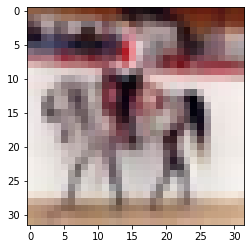

In [15]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [16]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [17]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [18]:
def get_pretrained_model(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
#     x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)    
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [19]:
resnet_model = get_pretrained_model(base_model)
resnet_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [20]:
lr = 1e-4
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
resnet_model.evaluate(test_ds)

78/78 [==============================] - 1s 11ms/step - loss: 6.2424 - accuracy: 0.0909


[6.242427349090576, 0.09094551205635071]

In [22]:
# We are going to train for 50 epochs
history = resnet_model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
390/390 [==============================] - 5s 13ms/step - loss: 1.9499 - accuracy: 0.4231 - val_loss: 1.2907 - val_accuracy: 0.5581
Epoch 2/50
390/390 [==============================] - 5s 13ms/step - loss: 1.2764 - accuracy: 0.5593 - val_loss: 1.1561 - val_accuracy: 0.6011
Epoch 3/50
390/390 [==============================] - 5s 13ms/step - loss: 1.1424 - accuracy: 0.6046 - val_loss: 1.1014 - val_accuracy: 0.6191
Epoch 4/50
390/390 [==============================] - 5s 14ms/step - loss: 1.0525 - accuracy: 0.6342 - val_loss: 1.0633 - val_accuracy: 0.6293
Epoch 5/50
390/390 [==============================] - 5s 14ms/step - loss: 0.9864 - accuracy: 0.6558 - val_loss: 1.0363 - val_accuracy: 0.6414
Epoch 6/50
390/390 [==============================] - 5s 13ms/step - loss: 0.9333 - accuracy: 0.6748 - val_loss: 1.0208 - val_accuracy: 0.6478
Epoch 7/50
390/390 [==============================] - 5s 14ms/step - loss: 0.8906 - accuracy: 0.6866 - val_loss: 1.0065 - val_accuracy: 0.6488

### Plot the plots

In [23]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

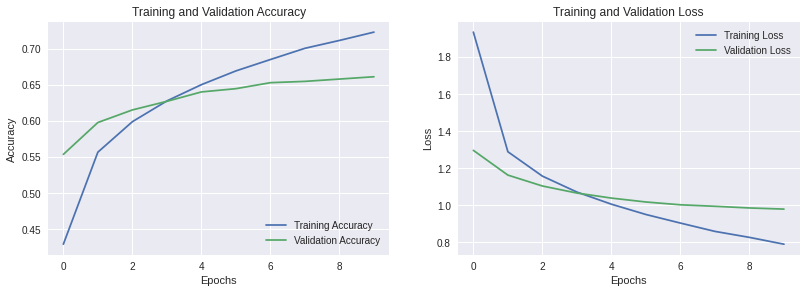

In [79]:
plot_history(history)